In [73]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

Constants taken from the code:

In [5]:
LOOKAHEAD_WPS = 200
MAX_DECEL = .5

Let's determine how far before the end of the list we should stop.

In [45]:
START_IDX = 0
STOP_IDX = LOOKAHEAD_WPS - 10
DEFAULT_VELOCITY = 10  # distance units per time unit

Let's generate some waypoints:

In [61]:
def generate_waypoints():
    waypoints_pose_x = np.linspace(0, LOOKAHEAD_WPS-1, LOOKAHEAD_WPS)
    return [(x, DEFAULT_VELOCITY) for x in waypoints_pose_x]

waypoints = generate_waypoints()

Next, a helper function for plotting.

In [130]:
def plot_waypoints(waypoints, title):
    positions = [wp[0] for wp in waypoints]
    velocities = [wp[1] for wp in waypoints]
    accelerations = np.ediff1d(velocities, 0)
    jerks = np.ediff1d(accelerations, 0)
    
    f, axs = plt.subplots(ncols=3, nrows=1, sharex=True, figsize=(15, 3))
    axs[0].plot(positions, velocities)
    axs[0].set_xlabel('distance')
    axs[0].set_ylabel('velocity')
    
    axs[1].plot(positions, accelerations)
    axs[1].set_xlabel('distance')
    axs[1].set_ylabel('acceleration')
    
    axs[2].plot(positions, jerks)
    axs[2].set_xlabel('distance')
    axs[2].set_ylabel('jerk')
    
    f.suptitle(title)
    sns.despine()

When we inspect the original waypoints, we're finding that we have constant velocity; consequently, both acceleration and jerk are constant as well.

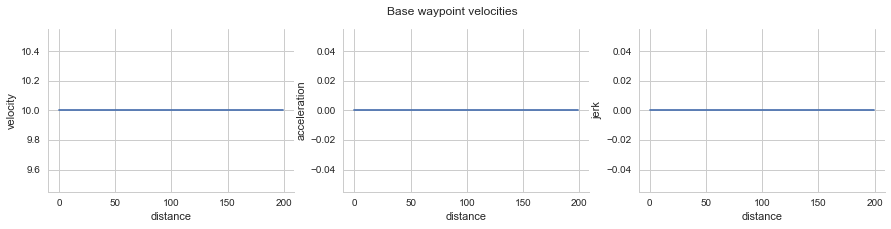

In [131]:
plot_waypoints(waypoints, 'Base waypoint velocities')

We know that the distances in our test setup here area always normalized and one-dimensional.
Instead of piecewise linear accumulation to determine the length, we could simply take the difference of the waypoint indices to know the distance between them.
However, this implementation is closer to the multidimensional case.

In [85]:
def distance(waypoints, wp1, wp2):
    dist = 0
    def dl(a, b): 
        return math.sqrt((a-b)**2)
    for i in range(wp1, wp2+1):
        dist += dl(waypoints[wp1][0], waypoints[i][0])
        wp1 = i
    return dist

## Baseline (`sqrt`) implementation

The following code plots the baseline implementation from the walkthrough sessions. It uses a square root function to reduce speed of the car until it stops at the desired location.

As was mentioned in the sessions (and is expected from the shape of the function), this will result in very abrupt steering behavior, since the derivatives at both the start and stop waypoints are nonzero.

In [285]:
def decelerate_waypoints_sqrt(waypoints, closest_idx, stopline_wp_idx, threshold=1):
        temp = []
        for i, (wp_x, wp_vel) in enumerate(waypoints):
            # Two waypoints back from the line so front of car stops at the line.
            # The "-2" offset
            stop_idx = max(stopline_wp_idx - closest_idx - 2, 0)
            dist = distance(waypoints, i, stop_idx)

            velocity = math.sqrt(2 * MAX_DECEL * dist)
            if velocity < threshold:
                velocity = 0.

            new_velocity = min(velocity, wp_vel)
            new_wp = [wp_x, new_velocity]
            temp.append(new_wp)
        return temp
    
wp_sqrt = decelerate_waypoints_sqrt(waypoints, START_IDX, STOP_IDX)

Here's a visualization of the resulting behavior:

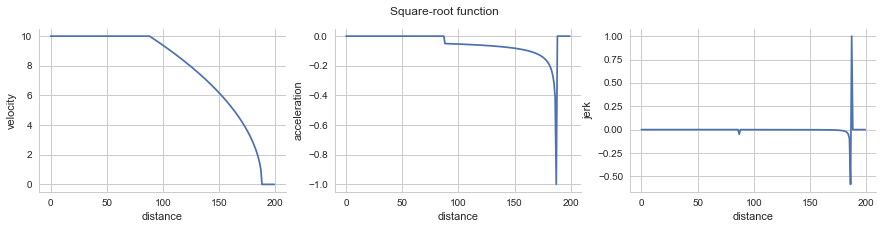

In [135]:
plot_waypoints(wp_sqrt, 'Square-root function')

This corresponds to hitting the brake as soon as we notice the stoplight, applying slightly more pressure over time, followed by a big step on the pedal at the stopping position.

It can be seen clearly that we're going to experience an abrupt change in both velocity, acceleration and jerk, none of which is comfortable. The hight jerk towards the end of the motion is due to the hard lower velocity threshold and the "high" deceleration we experienced before.

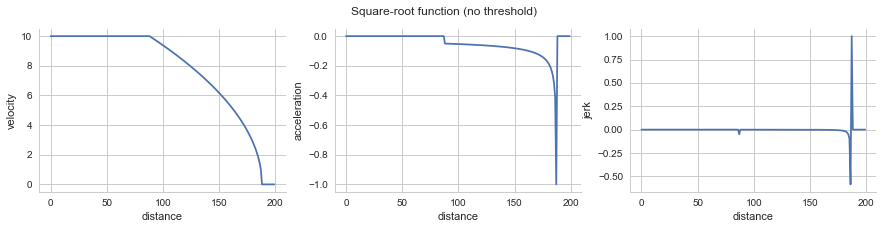

In [286]:
wp_sqrt_t0 = decelerate_waypoints_sqrt(waypoints, START_IDX, STOP_IDX, threshold=0)
plot_waypoints(wp_sqrt_t0, 'Square-root function (no threshold)')

When removing the lower threshold, we immediately see that most of this problem comes from the choice of the function to begin with.

## Linear deceleration

Another approach would be to linearly decelerate over time; as before, this is expected to be unpleasant since, again, two nonzero derivatives of velocity and acceleration are involved.

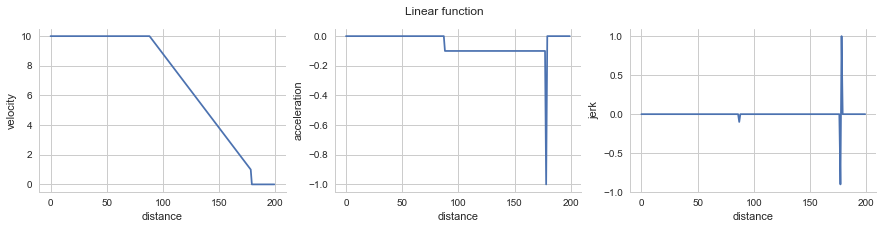

In [470]:
def decelerate_way_points_linear(waypoints, closest_idx, stopline_wp_idx, threshold=1):
        temp = []
        for i, (wp_x, wp_vel) in enumerate(waypoints):
            # Two waypoints back from the line so front of car stops at the line.
            # The "-2" offset
            stop_idx = max(stopline_wp_idx - closest_idx - 2, 0)
            dist = distance(waypoints, i, stop_idx)

            alpha = 0.1
            velocity = alpha * dist
            if velocity < threshold:
                velocity = 0.

            new_velocity = min(velocity, wp_vel)
            new_wp = [wp_x, new_velocity]
            temp.append(new_wp)
        return temp
    
wp_linear = decelerate_way_points_linear(waypoints, START_IDX, STOP_IDX)
plot_waypoints(wp_linear, 'Linear function')

As expected, both in the beginning, as well as close to the stop, we're going to experience some jerk; again, the final jerk is due to the threshold being applied.

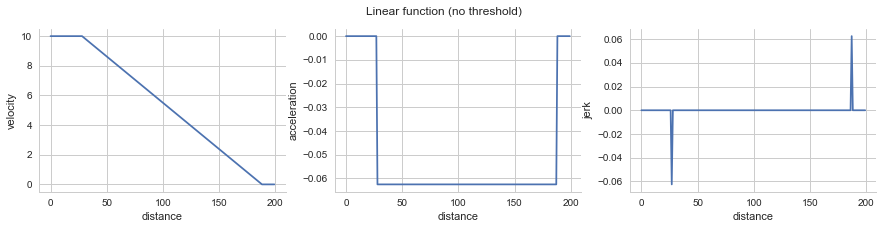

In [289]:
wp_linear_t0 = decelerate_way_points_linear(waypoints, START_IDX, STOP_IDX, threshold=0)
plot_waypoints(wp_linear_t0, 'Linear function (no threshold)')

If we don't apply a lower threshold, the jerk plot looks a bit nicer, but the underlying problem is still obvious.

## Sigmoidal deceleration

A class of function that both starts and stops smoothly are sigmoid-likes, such as the sine (`sin`), the tangens hyperbolicus (`tanh`), and the logistic function(s).

### Sine

The sine is a bit problematic due to its cyclic nature; if we were to overshoot, the function would dictate to accelerate again.

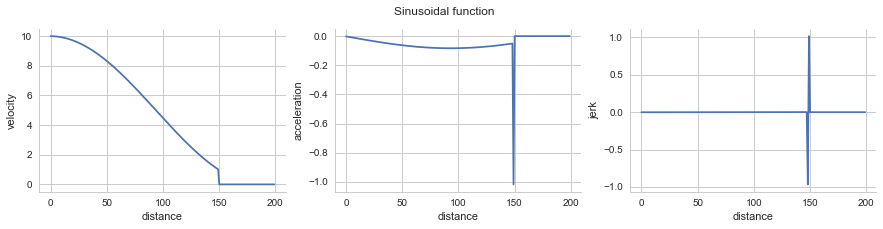

In [306]:
def decelerate_way_points_sine(waypoints, closest_idx, stopline_wp_idx, threshold=1):
        temp = []
        for i, (wp_x, wp_vel) in enumerate(waypoints):
            # Two waypoints back from the line so front of car stops at the line.
            # The "-2" offset
            stop_idx = max(stopline_wp_idx - closest_idx - 2, 0)
            dist = distance(waypoints, i, stop_idx)

            alpha = wp_vel
            beta = 2.12 * np.pi / LOOKAHEAD_WPS
            gamma = -np.pi/2
            velocity = alpha * 0.5 * (math.sin(beta * MAX_DECEL * dist + gamma) + 1.)
            if velocity < threshold:
                velocity = 0.

            new_velocity = min(velocity, wp_vel)
            new_wp = [wp_x, new_velocity]
            temp.append(new_wp)
        return temp
    
wp_sine = decelerate_way_points_sine(waypoints, START_IDX, STOP_IDX)
plot_waypoints(wp_sine, 'Sinusoidal function')

The acceleration profile looks a lot better now, except for the jerk due to the threshold. An interesting picture appears when we remove it:

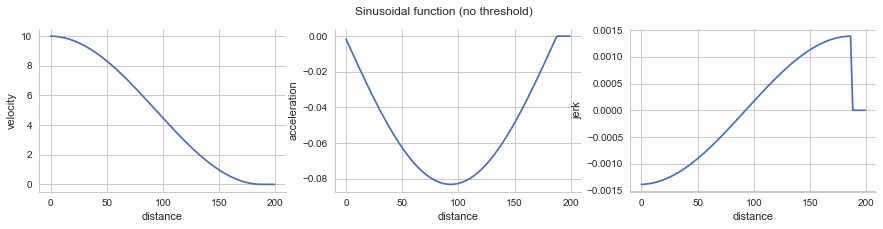

In [307]:
wp_sine_t0 = decelerate_way_points_sine(waypoints, START_IDX, STOP_IDX, threshold=0)
plot_waypoints(wp_sine_t0, 'Sinusoidal function (no threshold)')

Even though the function now smoothly decelerates, the we find that neither the acceleration, nor the jerk profile are smooth - they are jumping from `0` to a nonzero value and back.

Given the absolute value of the jumps we can simply chose to ignore them, as they should be way in the comfort zone.

The problem changes a bit the closer we get to the stopping position since the function itself is parameterized on the initial distance. To use it, it would make sense to store the initial point at which the obstacle was observed and the decision was taken to brake.

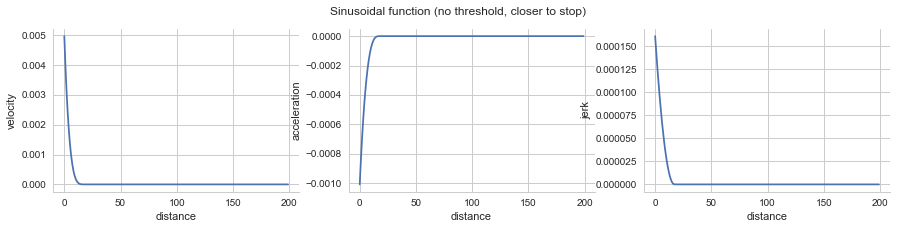

In [381]:
wp_sine_t0_shifted = decelerate_way_points_sine(wp_sine_t0, STOP_IDX - 20, STOP_IDX, threshold=0)
plot_waypoints(wp_sine_t0_shifted, 'Sinusoidal function (no threshold, closer to stop)')

### Logistic function

The logistic function is centered around `e`, which has the nice propery of being its own derivative. This implies that using the logistic function for a smooth acceleration profile, the jerk profile will be smooth as well by definition.

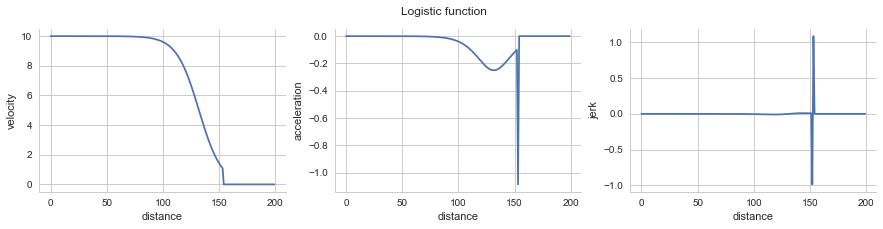

In [446]:
def decelerate_way_points_logistic(waypoints, closest_idx, stopline_wp_idx, threshold=1, gamma=10, delta=10, beta=0.1):
        temp = []
        for i, (wp_x, wp_vel) in enumerate(waypoints):
            # Two waypoints back from the line so front of car stops at the line.
            # The "-2" offset
            stop_idx = max(stopline_wp_idx - closest_idx - 2, 0)
            dist = distance(waypoints, i, stop_idx)

            alpha = wp_vel
            velocity = alpha / (1. + np.exp(-beta * (dist - delta)) * gamma*alpha)
            if velocity < threshold:
                velocity = 0.

            new_velocity = min(velocity, wp_vel)
            new_wp = [wp_x, new_velocity]
            temp.append(new_wp)
        return temp
    
wp_logistic = decelerate_way_points_logistic(waypoints, START_IDX, STOP_IDX)
plot_waypoints(wp_logistic, 'Logistic function')

From this graph, we find that deceleration smoothly increases and jerk is almost unnoticeable, except for the final threshold.

Due to the nature of the logistic function - approaching its extrema only at positive or negative infinity - there will always be a jump in the function; due to this, we're going to "experience" a jerk. There's only so much we can do about it, as fine-tuning the values will incur a precision penalty at some point due to the limited precision of IEEE-754 floating point values.

When looking at the scale of the jerk though, this is really not an issue at all.

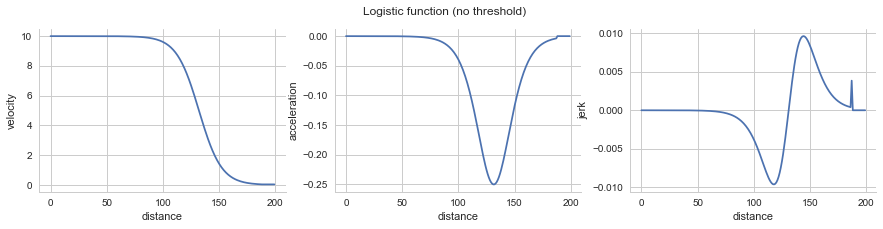

In [447]:
wp_logistic_t0 = decelerate_way_points_logistic(waypoints, START_IDX, STOP_IDX, threshold=0)
plot_waypoints(wp_logistic_t0, 'Logistic function (no threshold)')

Again, when running the function against pre-determined values again, the profile changes quite a lot. Given the absolute amount of jerk experienced, this is not going to be problematic.

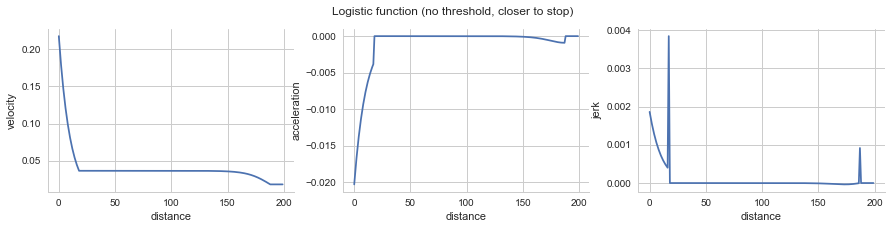

In [448]:
wp_logistic_t0_shifted = decelerate_way_points_logistic(wp_logistic_t0, STOP_IDX - 20, STOP_IDX, threshold=0)
plot_waypoints(wp_logistic_t0_shifted, 'Logistic function (no threshold, closer to stop)')

We can decide to delay the brake point further so that the doesn't stop too early.

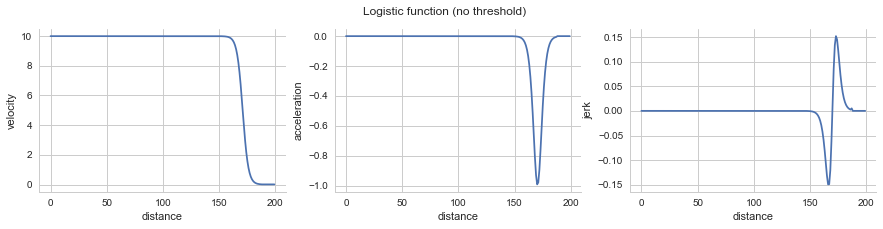

In [468]:
wp_logistic_t0_gd = decelerate_way_points_logistic(waypoints, START_IDX, STOP_IDX, threshold=0, 
                                                   beta=.4, delta=-.1, gamma=100)
plot_waypoints(wp_logistic_t0_gd, 'Logistic function (no threshold)')